In [9]:
# Read Fashion MNIST dataset
%matplotlib inline
import seaborn as sn
import pandas as pd
import numpy as np
import util_mnist_reader as mnist_reader
import matplotlib.pyplot as plt
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [ ]:
y_train

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

In [19]:
from sklearn.cluster import KMeans
X_train=X_train/256.0
X_test=X_test/256.0

In [20]:
# create kmeans object
kmeans = KMeans(n_clusters=10)
# fit kmeans object to data
kmeans.fit(X_train)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
#y_km = kmeans.fit_predict(X_test)

[[ 1.45689667e-19  9.73141300e-05  3.17791456e-04 ...  3.46195018e-02
   1.44359430e-02  1.90826927e-03]
 [ 2.66391862e-19 -5.11607900e-19  1.10046521e-17 ... -1.38777878e-16
  -2.80591522e-16  2.90566182e-17]
 [ 2.87991202e-19 -5.21772296e-19  1.91632734e-17 ...  1.66359981e-15
  -6.53990750e-16  4.28801959e-17]
 ...
 [ 7.04917505e-06  1.30913251e-05  8.10655130e-05 ...  1.21079652e-02
   5.18265420e-03  3.31814740e-04]
 [ 1.37413746e-05  4.33381816e-05  3.10237958e-04 ...  3.47233967e-04
   9.77751657e-05  1.21558314e-05]
 [ 1.27054942e-19  6.66027280e-06  9.32438193e-05 ...  2.34608110e-03
   1.70003463e-03  3.79635550e-04]]


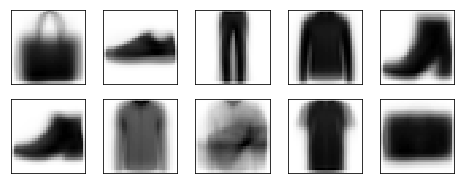

In [21]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [22]:
clusters = kmeans.predict(X_test)
kmeans.cluster_centers_.shape

(10, 784)

In [23]:
max(clusters)

9

Using mode for calculating the accuracy

In [24]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(y_test[mask])[0]

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, labels)

0.5599

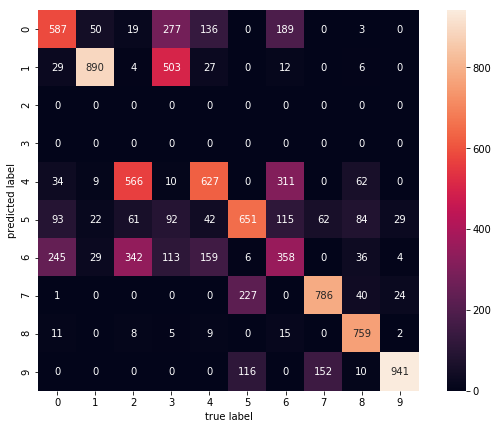

In [26]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, labels)
plt.figure(figsize = (10,7))
sn.heatmap(mat.T, square=True, annot=True, fmt='d')

plt.xlabel('true label')
plt.ylabel('predicted label');

In [27]:
from keras.utils import to_categorical
to_categorical(labels)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

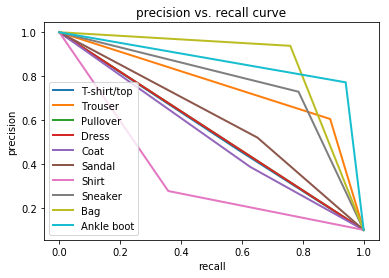

In [28]:
from sklearn.metrics import precision_recall_curve, roc_curve
precision2 = dict()
recall2 = dict()
type_of_fashion=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
for i in range(10):
    precision2[i], recall2[i], _ = precision_recall_curve((to_categorical(y_test))[:, i],
                                                        (to_categorical(labels))[:, i])
    plt.plot(recall2[i], precision2[i], lw=2, label='{}'.format(type_of_fashion[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

####################
Auto encoder k-means

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12664589223903235184
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3153697177
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3123715493068048747
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import keras

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from keras.models import Model , Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adadelta, RMSprop,SGD,Adam

In [10]:
train_data = X_train.reshape(-1, 28,28, 1)
test_data = X_test.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [11]:
batch_size = 64
epochs = 100
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [12]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [14]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img)
    conv1 = BatchNormalization()(conv1)#28 x 28 x 32
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='valid', strides=2)(conv1)
    conv2 = BatchNormalization()(conv2)
    flat = Flatten()(conv2)
    hidden1 = Dense(10, activation='relu')(flat)
    return hidden1

def decoder(hidden1):    
    #decoder
    hidden2 = Dense(1152, activation='relu')(hidden1)
    hidden2 = Reshape((3,3,128), name='predictions')(hidden2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(hidden2) 
    conv3 = BatchNormalization()(conv3)
    up1 = UpSampling2D((2,2))(conv3)
    up1 = UpSampling2D((2,2))(up1)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    conv4 = BatchNormalization()(conv4)
    conv5 = Conv2D(32, (6, 6), activation='relu', padding='valid')(conv4) 
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    decoded = UpSampling2D((2,2))(decoded)
    return decoded


In [15]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
autoencoder.summary()
#encoder=Model(input_img,encoder(input_img))
#encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 3, 128)         512       
__________

In [17]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=100,verbose=1,validation_data=(valid_X, valid_ground))

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 14s 297us/step - loss: 0.0342 - val_loss: 0.0307
Epoch 2/100
48000/48000 [==============================] - 11s 222us/step - loss: 0.0256 - val_loss: 0.0279
Epoch 3/100
48000/48000 [==============================] - 11s 232us/step - loss: 0.0244 - val_loss: 0.0264
Epoch 4/100
48000/48000 [==============================] - 11s 221us/step - loss: 0.0237 - val_loss: 0.0232
Epoch 5/100
48000/48000 [==============================] - 11s 229us/step - loss: 0.0233 - val_loss: 0.0228
Epoch 6/100
48000/48000 [==============================] - 11s 229us/step - loss: 0.0230 - val_loss: 0.0231
Epoch 7/100
48000/48000 [==============================] - 10s 216us/step - loss: 0.0227 - val_loss: 0.0227
Epoch 8/100
48000/48000 [==============================] - 11s 221us/step - loss: 0.0225 - val_loss: 0.0223
Epoch 9/100
48000/48000 [=============

48000/48000 [==============================] - 10s 215us/step - loss: 0.0205 - val_loss: 0.0208
Epoch 74/100
48000/48000 [==============================] - 10s 210us/step - loss: 0.0205 - val_loss: 0.0208
Epoch 75/100
48000/48000 [==============================] - 11s 223us/step - loss: 0.0205 - val_loss: 0.0208
Epoch 76/100
48000/48000 [==============================] - 11s 221us/step - loss: 0.0205 - val_loss: 0.0208
Epoch 77/100
48000/48000 [==============================] - 11s 226us/step - loss: 0.0205 - val_loss: 0.0208
Epoch 78/100
48000/48000 [==============================] - 10s 216us/step - loss: 0.0205 - val_loss: 0.0207
Epoch 79/100
48000/48000 [==============================] - 10s 211us/step - loss: 0.0205 - val_loss: 0.0208
Epoch 80/100
48000/48000 [==============================] - 10s 208us/step - loss: 0.0205 - val_loss: 0.0208
Epoch 81/100
48000/48000 [==============================] - 10s 212us/step - loss: 0.0205 - val_loss: 0.0207
Epoch 82/100
48000/48000 [======

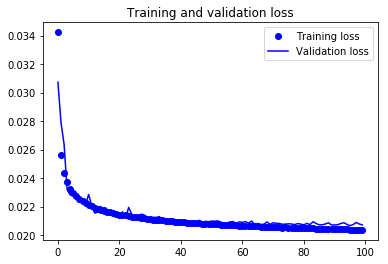

In [18]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#autoencoder.save('autoencoder(final).h5')

In [ ]:
#autoencoder = decoder(encoder(input_img))

In [9]:
from keras.models import load_model

autoencoder=load_model('autoencoder(final).h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 3, 3, 128)         512       
__________

In [11]:
restored_testing_dataset = autoencoder.predict(test_data)

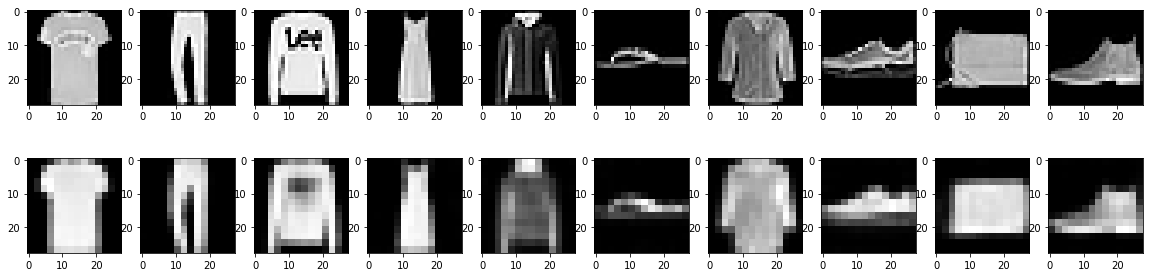

In [12]:
plt.figure(figsize=(20,5))
for i in range(10):
    index = y_test.tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[index].reshape((28,28)))
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(restored_testing_dataset[index].reshape((28,28)))
    plt.gray()

In [13]:
encoder = K.function([autoencoder.layers[0].input], [autoencoder.layers[8].output])

In [14]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 3, 3, 128)         512       
__________

In [15]:
encoded_test_images = encoder([test_data])[0].reshape(-1,1*10*1)

In [16]:
encoded_train_images1 = encoder([train_data[:10000]])[0].reshape(-1,1*10*1)

In [17]:
encoded_train_images=encoded_train_images1

In [18]:
for x in range(5):
    print(x)
    encoded_train_images2 = encoder([train_data[(x+1)*10000:(x+2)*10000]])[0].reshape(-1,1*10*1)
    encoded_train_images=np.concatenate((encoded_train_images, encoded_train_images2), axis=0)

0
1
2
3
4


In [19]:
encoded_train_images.shape

(60000, 10)

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
clustered_training_set = kmeans.fit(encoded_train_images)

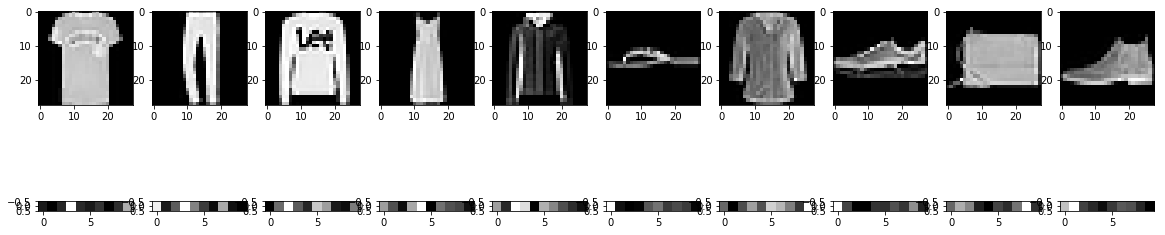

In [23]:
plt.figure(figsize=(20,5))
for i in range(10):
    index = y_test.tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[index].reshape((28,28)))
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(encoded_test_images[index].reshape((1,10)))
    plt.gray()

In [24]:
print(kmeans.cluster_centers_)

[[ 92.91263   28.545515  38.844875 101.21614   96.989525  27.152925
   28.720516  56.889328  22.781723  23.73184 ]
 [ 47.19959  111.34349   33.59588   28.827866  50.319393  45.98233
   39.78293   55.347717  39.08201   32.07566 ]
 [ 40.700237  43.333164 139.81567   86.718544  53.971394  93.78134
   99.059006  59.30939   57.352787  79.93756 ]
 [ 31.079994  26.22086   46.270287  63.03607   31.704031  50.4328
   45.537914  30.780268  31.895634  42.44749 ]
 [ 82.16551  164.3995    60.93206   56.598267  50.538486  30.28525
   75.35089  108.87134   59.825844  60.307274]
 [ 70.53561   46.610542  70.51906  150.6259    96.633095  50.52431
   66.966225  53.432777  54.276882  53.184036]
 [ 64.08894   49.79169   58.832832  64.46622   26.729061  46.628532
  169.3431    44.271996  68.66142   38.209503]
 [ 71.162415  74.16441   94.15785   40.01586   24.95371   41.70951
   63.708263  42.149906 145.53613  100.31045 ]
 [ 60.599316  34.78147   43.13856  150.19452   61.01029   55.413467
   61.954136  46.18

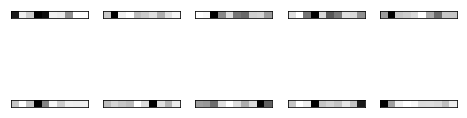

In [25]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 1, 10)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [37]:
pred = kmeans.predict(encoded_test_images)

In [38]:
pred.shape

(10000,)

In [39]:
from scipy.stats import mode

labels = np.zeros_like(pred)
for i in range(10):
    mask = (pred == i)
    labels[mask] = mode(y_test[mask])[0]

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, labels)

0.5916

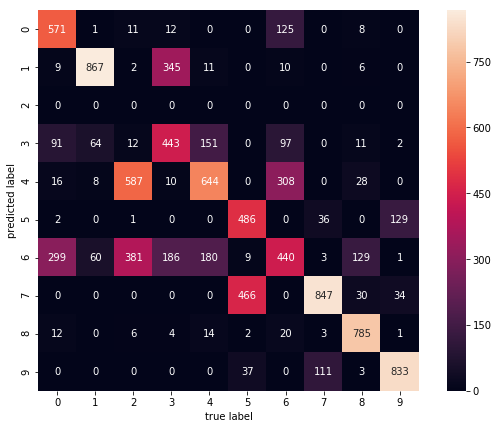

In [40]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, labels)
plt.figure(figsize = (10,7))
sn.heatmap(mat.T, square=True, annot=True, fmt='d')

plt.xlabel('true label')
plt.ylabel('predicted label');

################Gaussian Mixture Model #######################

In [30]:
from sklearn.mixture import GaussianMixture

In [31]:
gmm = GaussianMixture(n_components=10, covariance_type='full').fit(encoded_train_images)

In [32]:
prediction_gmm = gmm.predict(encoded_test_images)

In [33]:
from scipy.stats import mode

labels = np.zeros_like(prediction_gmm)
for i in range(10):
    mask = (prediction_gmm == i)
    labels[mask] = mode(y_test[mask])[0]

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, labels)

0.6186

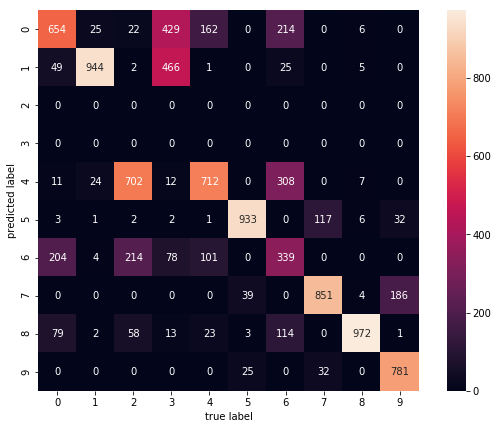

In [35]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, labels)
plt.figure(figsize = (10,7))
sn.heatmap(mat.T, square=True, annot=True, fmt='d')

plt.xlabel('true label')
plt.ylabel('predicted label');